# DCGAN with SVHN dataset

In [29]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Data Load

In [30]:
train_data = loadmat("train_32x32.mat")
test_data = loadmat("test_32x32.mat")

In [31]:
X_train, y_train = train_data["X"], train_data["y"]
X_test, y_test = test_data["X"], test_data["y"]

X_train.shape

(32, 32, 3, 73257)

In [32]:
X_train = np.rollaxis(X_train, 3, 0)
X_test = np.rollaxis(X_test, 3, 0)

print(X_train.shape)
print(X_test.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


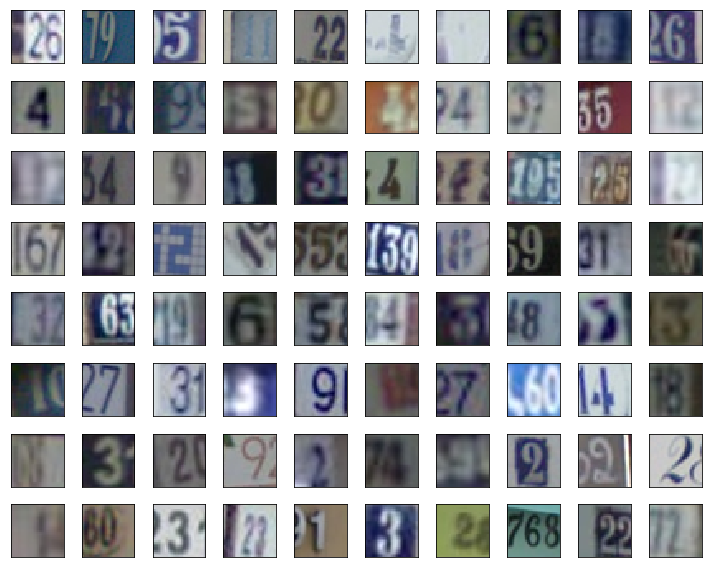

In [33]:
sample_images = X_train[np.random.choice(len(X_train), size=80, replace=False)]

plt.figure(figsize=(10, 8))
for i in range(80):
    plt.subplot(8, 10, i+1)
    plt.imshow(sample_images[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Preprocessing

In [34]:
def preprocess(x):
    return (x/255)*2-1
def deprocess(x):
    return np.uint8((x+1)/2*255)

In [35]:
X_train_real = preprocess(X_train)
X_test_real = preprocess(X_test)

## Generator

In [40]:
def make_generator(input_size, leaky_alpha):
    return Sequential([
        Dense(4*4*512, input_shape=(input_size, )),
        Reshape(target_shape=(4, 4, 512)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
    
        Conv2DTranspose(256, kernel_size=5, strides=2, padding="same"),    # 8x8x256
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
    
        Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"),    # 16x16x128
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
    
        Conv2DTranspose(3, kernel_size=5, strides=2, padding="same"),      # 32x32x3
        Activation("tanh")
    ])
        
    

## Discriminator

In [41]:
def make_discriminator(leaky_alpha):
    return Sequential([
        Conv2D(64, kernel_size=5, strides=2, padding="same", input_shape=(32,32,3)),  # 16x16x64
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        Conv2D(128, kernel_size=5, strides=2, padding="same"),  # 8x8x128
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        Conv2D(256, kernel_size=5, strides=2, padding="same"),  # 4x4x256
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        Flatten(),
        Dense(1),
        Activation("sigmoid")  
    ])

In [42]:
gen = make_generator(100, 0.01)
disc = make_discriminator(0.01)
    

In [43]:
gen.summary()
disc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 256)         0         
__________

## DCGAN

In [44]:
def make_DCGAN(sample_size,
              g_lr,
              g_beta_1,
              d_lr,
              d_beta_1,
              leaky_alpha):
    
    K.clear_session()
    
    generator = make_generator(sample_size, leaky_alpha)
    discriminator = make_discriminator(leaky_alpha)
    
    discriminator.compile(optimizer=Adam(lr=d_lr, beta_1=d_beta_1), loss="binary_crossentropy")
    
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_lr, beta_1=g_beta_1), loss="binary_crossentropy")
    
    return gan, generator, discriminator
    
    

## Training DCGAN

In [45]:
def make_latent_samples(n_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [46]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [47]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [48]:
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label="Discriminator"),
    plt.plot(losses.T[1], label="Generator"),
    plt.title("Validation Losses"),
    plt.legend()
    plt.show()

In [49]:
def show_images(generated_images):
    n_images = len(generated_images)
    cols = 10
    rows = n_images//cols
    
    plt.figure(figsize=(10, 8))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [50]:
def train(
    g_learning_rate, # learning rate for the generator
    g_beta_1,        # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate, # learning rate for the discriminator
    d_beta_1,        # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    smooth=0.1,
    sample_size=100, # latent sample size (i.e. 100 random numbers)
    epochs=25,
    batch_size= 128, # train batch size
    eval_size=16,    # evaluate size
    show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real SVHN digit images
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

            # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch: {:>3}/{} Discriminator Loss: {:>7.4f}  Generator Loss: {:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))

        # show the generated images
        if (e+1) % 5 == 0:
            show_images(X_eval_fake[:10])
    
    if show_details:
        show_losses(losses)
        show_images(generator.predict(make_latent_samples(80, sample_size)))    
    return generator

## Training

c:\users\toem\anaconda2\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/25 Discriminator Loss:  8.6496  Generator Loss:  1.5510
Epoch:   2/25 Discriminator Loss: 12.3949  Generator Loss:  2.9712
Epoch:   3/25 Discriminator Loss:  9.3584  Generator Loss:  1.2244
Epoch:   4/25 Discriminator Loss: 14.5749  Generator Loss:  0.6378
Epoch:   5/25 Discriminator Loss: 12.4899  Generator Loss:  3.5049


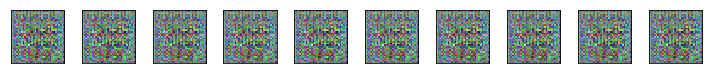

Epoch:   6/25 Discriminator Loss: 15.3206  Generator Loss:  0.8917
Epoch:   7/25 Discriminator Loss:  7.2972  Generator Loss:  7.3117
Epoch:   8/25 Discriminator Loss:  8.4746  Generator Loss:  8.0631
Epoch:   9/25 Discriminator Loss: 20.3564  Generator Loss:  0.0050
Epoch:  10/25 Discriminator Loss:  3.6944  Generator Loss:  1.0149


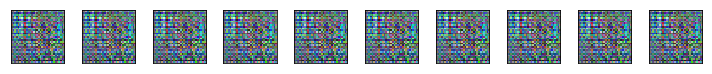

Epoch:  11/25 Discriminator Loss:  5.1583  Generator Loss:  0.3667
Epoch:  12/25 Discriminator Loss:  8.7705  Generator Loss:  4.9889
Epoch:  13/25 Discriminator Loss: 14.6354  Generator Loss:  0.0077
Epoch:  14/25 Discriminator Loss:  1.6087  Generator Loss:  2.5009
Epoch:  15/25 Discriminator Loss:  1.0758  Generator Loss:  2.0690


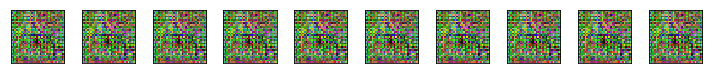

Epoch:  16/25 Discriminator Loss:  2.8070  Generator Loss:  3.0924
Epoch:  17/25 Discriminator Loss:  3.7447  Generator Loss:  0.3018
Epoch:  18/25 Discriminator Loss: 11.3997  Generator Loss:  5.1429
Epoch:  19/25 Discriminator Loss:  5.7320  Generator Loss:  4.5038
Epoch:  20/25 Discriminator Loss:  2.3802  Generator Loss:  0.8832


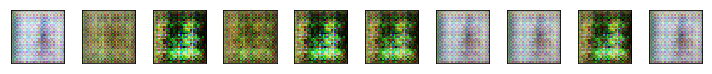

Epoch:  21/25 Discriminator Loss:  0.7207  Generator Loss:  3.7662
Epoch:  22/25 Discriminator Loss:  2.5257  Generator Loss:  0.1687
Epoch:  23/25 Discriminator Loss:  2.6774  Generator Loss:  0.2286
Epoch:  24/25 Discriminator Loss:  2.4394  Generator Loss:  2.7617
Epoch:  25/25 Discriminator Loss:  3.7433  Generator Loss:  2.5312


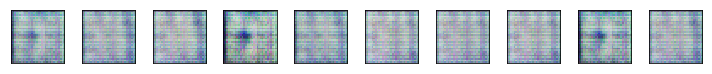

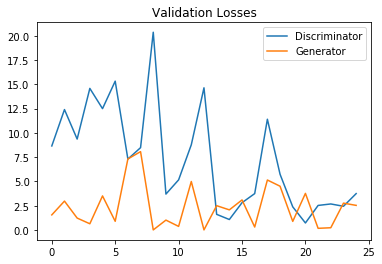

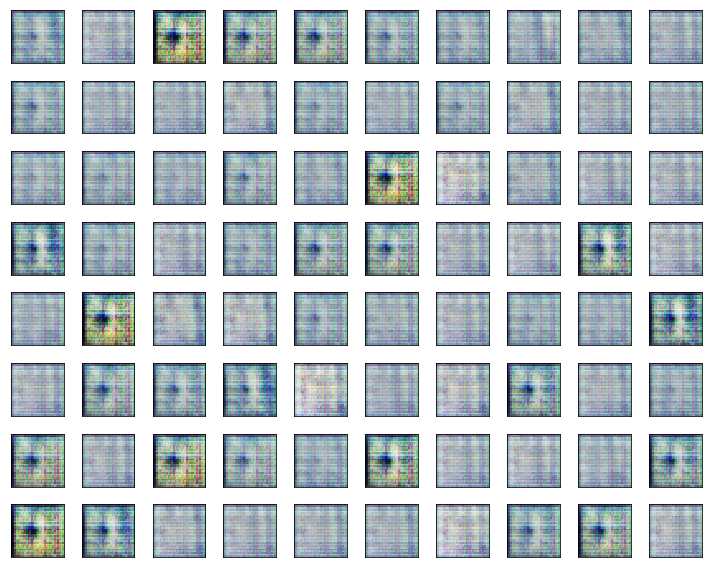

In [23]:
# kleines network
train(g_learning_rate=0.0002, g_beta_1=0.5, d_learning_rate=0.0002, d_beta_1=0.5, leaky_alpha=0.2);


c:\users\toem\anaconda2\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/25 Discriminator Loss:  1.9800  Generator Loss: 10.6556
Epoch:   2/25 Discriminator Loss:  1.3367  Generator Loss:  1.6963
Epoch:   3/25 Discriminator Loss:  1.4352  Generator Loss:  2.8423
Epoch:   4/25 Discriminator Loss:  2.1922  Generator Loss:  2.9369
Epoch:   5/25 Discriminator Loss:  1.4764  Generator Loss:  2.2678


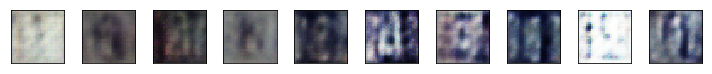

Epoch:   6/25 Discriminator Loss:  1.2809  Generator Loss:  1.3673
Epoch:   7/25 Discriminator Loss:  2.4097  Generator Loss:  2.0374
Epoch:   8/25 Discriminator Loss:  1.2446  Generator Loss:  1.8287
Epoch:   9/25 Discriminator Loss:  1.2829  Generator Loss:  2.6623
Epoch:  10/25 Discriminator Loss:  2.8128  Generator Loss:  3.9173


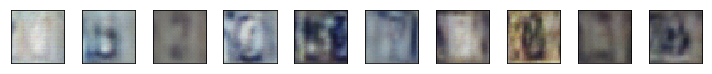

Epoch:  11/25 Discriminator Loss:  1.8928  Generator Loss:  3.3804
Epoch:  12/25 Discriminator Loss:  2.4085  Generator Loss:  3.8863
Epoch:  13/25 Discriminator Loss:  2.9197  Generator Loss:  3.9463
Epoch:  14/25 Discriminator Loss:  2.9888  Generator Loss:  3.6538
Epoch:  15/25 Discriminator Loss:  2.8418  Generator Loss:  4.4895


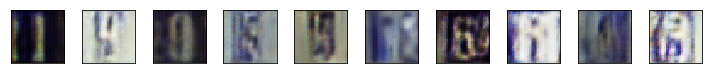

Epoch:  16/25 Discriminator Loss:  2.9803  Generator Loss:  4.5417
Epoch:  17/25 Discriminator Loss:  3.9189  Generator Loss:  4.3114
Epoch:  18/25 Discriminator Loss:  2.8398  Generator Loss:  3.9870
Epoch:  19/25 Discriminator Loss:  3.0667  Generator Loss:  4.3785
Epoch:  20/25 Discriminator Loss:  2.8842  Generator Loss:  4.4585


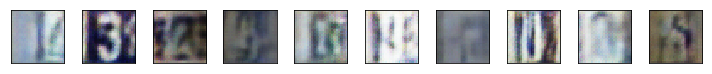

Epoch:  21/25 Discriminator Loss:  2.7919  Generator Loss:  3.7076
Epoch:  22/25 Discriminator Loss:  3.0582  Generator Loss:  4.5341
Epoch:  23/25 Discriminator Loss:  3.2341  Generator Loss:  3.3185
Epoch:  24/25 Discriminator Loss:  3.5059  Generator Loss:  3.9673
Epoch:  25/25 Discriminator Loss:  3.2582  Generator Loss:  4.3973


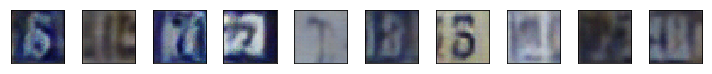

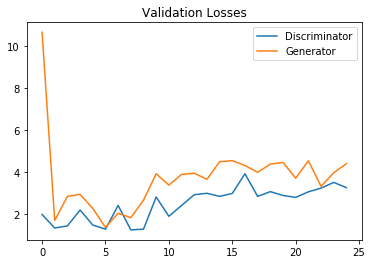

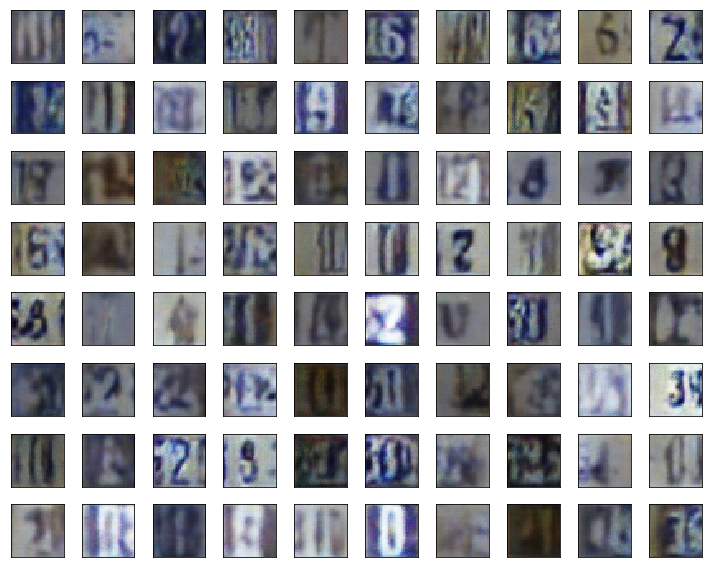

In [24]:
# kleines network
train(g_learning_rate=0.0001, g_beta_1=0.5, d_learning_rate=0.001, d_beta_1=0.5, leaky_alpha=0.2);


c:\users\toem\anaconda2\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/25 Discriminator Loss:  0.9307  Generator Loss:  1.5906
Epoch:   2/25 Discriminator Loss:  2.6453  Generator Loss:  1.1838
Epoch:   3/25 Discriminator Loss: 16.1855  Generator Loss:  2.8120
Epoch:   4/25 Discriminator Loss:  1.7715  Generator Loss:  0.2564
Epoch:   5/25 Discriminator Loss:  1.2994  Generator Loss:  0.8330


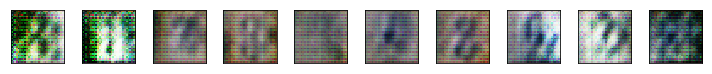

Epoch:   6/25 Discriminator Loss:  1.4538  Generator Loss:  1.3623
Epoch:   7/25 Discriminator Loss:  1.2532  Generator Loss:  0.6455
Epoch:   8/25 Discriminator Loss:  1.0139  Generator Loss:  0.9888
Epoch:   9/25 Discriminator Loss:  1.1852  Generator Loss:  1.0441
Epoch:  10/25 Discriminator Loss:  1.9251  Generator Loss:  1.6587


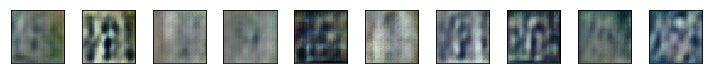

Epoch:  11/25 Discriminator Loss:  1.5905  Generator Loss:  1.8911
Epoch:  12/25 Discriminator Loss:  3.3233  Generator Loss:  3.6219
Epoch:  13/25 Discriminator Loss:  2.1756  Generator Loss:  3.0855
Epoch:  14/25 Discriminator Loss:  2.9223  Generator Loss:  4.0668
Epoch:  15/25 Discriminator Loss:  3.5649  Generator Loss:  3.7698


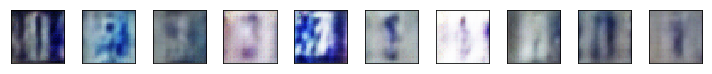

Epoch:  16/25 Discriminator Loss:  3.4890  Generator Loss:  3.1945
Epoch:  17/25 Discriminator Loss:  2.7005  Generator Loss:  4.3955
Epoch:  18/25 Discriminator Loss:  2.5299  Generator Loss:  3.5507
Epoch:  19/25 Discriminator Loss:  3.1595  Generator Loss:  4.0033
Epoch:  20/25 Discriminator Loss:  1.5137  Generator Loss:  3.1403


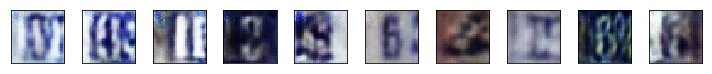

Epoch:  21/25 Discriminator Loss:  3.1818  Generator Loss:  3.6044
Epoch:  22/25 Discriminator Loss:  3.1182  Generator Loss:  4.0101
Epoch:  23/25 Discriminator Loss:  3.0517  Generator Loss:  3.7719
Epoch:  24/25 Discriminator Loss:  3.2999  Generator Loss:  3.1206
Epoch:  25/25 Discriminator Loss:  3.0870  Generator Loss:  4.6026


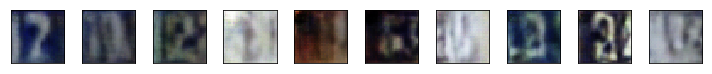

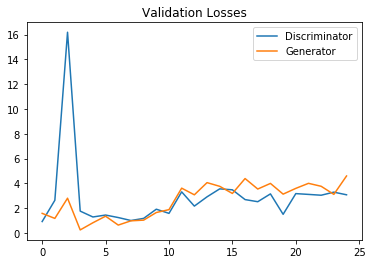

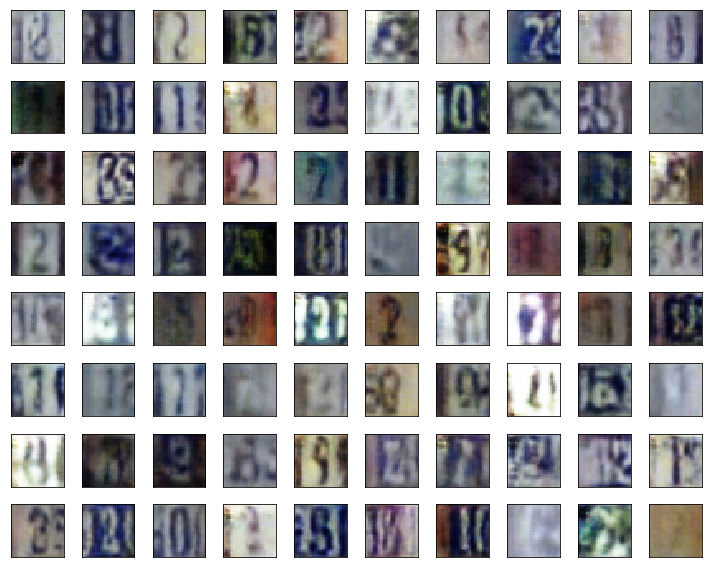

In [51]:
# standard netzwerk
train(g_learning_rate=0.0001, g_beta_1=0.5, d_learning_rate=0.001, d_beta_1=0.5, leaky_alpha=0.2);